In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import numpy
import root_numpy
from utils import shrink_floats
import os

## Read the data

In [3]:
data = pandas.DataFrame(root_numpy.root2array('../data/global_train.root', 'tree'))
shrink_floats(data)

In [4]:
data_test = pandas.DataFrame(root_numpy.root2array('../data/global_test.root', 'tree'))
shrink_floats(data_test)

In [5]:
len(data)

5999993

In [6]:
data.head()

,VeloCharge,BremPIDe,CaloNeutralPrs,CaloNeutralSpd,InAccBrem,InAccSpd,CaloPrsE,InAccPrs,HcalPIDe,CaloHcalE,...,piplus_OWNPV_XERR,piplus_OWNPV_YERR,piplus_OWNPV_ZERR,piplus_OWNPV_CHI2,piplus_OWNPV_NDOF,piplus_IP_OWNPV,piplus_IPCHI2_OWNPV,nCandidate,totCandidates,EventInSequence
0,1.028090,-999,-999,-999,0,0,-999.000000,0,-999.000000,-999.000000,...,0.0096,0.0096,0.0532,33.816654,83,0.111340,15.622943,16,37,9099
1,1.044008,-999,-999,-999,0,0,-999.000000,0,-999.000000,-999.000000,...,0.0064,0.0063,0.0358,67.432457,187,0.025907,0.510528,38,106,12220
2,0.853933,-999,-999,-999,0,1,155.237808,1,-1.926180,27002.507812,...,0.0108,0.0108,0.0557,29.747982,67,0.136919,5.520920,14,76,8573
3,1.306180,-999,-999,-999,0,1,11.793685,1,0.434916,0.000000,...,0.0086,0.0084,0.0453,45.295311,97,0.572526,2.692502,25,50,13449
4,0.969101,-999,-999,-999,0,1,113.548508,1,1.788384,0.000000,...,0.0115,0.0110,0.0773,33.635342,71,0.101532,4.014179,24,86,1379


#### add signal column (from 0 to 5 classes), weights (to balance data), charges (to check assymetry)

In [7]:
from utils import compute_labels_and_weights, compute_charges, names_labels_correspondence, labels_names_correspondence
from utils import roc_auc_score_one_vs_all_for_separate_algorithms

In [8]:
data['Signal'], data['Weight'] = compute_labels_and_weights(data.MCParticleType.values)
data['Charge'] =  compute_charges(data.MCParticleType.values)

In [9]:
data_test['Signal'], data_test['Weight'] = compute_labels_and_weights(data_test.MCParticleType.values)
data_test['Charge'] =  compute_charges(data_test.MCParticleType.values)

# Train, test splitting

In [10]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(data, train_size=600000, random_state=19)

In [11]:
len(train)

600000

# Define features

In [12]:
from collections import OrderedDict
features = OrderedDict()
features['Ghost'] = ['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability',
                     'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF',
                     'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres', 
                     'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 
                     'MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 'MuonIsLooseMuon', 
                     'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']

features['Electron'] = ['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability', 
                        'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF',
                        'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres',
                        'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 
                        'MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 'MuonIsLooseMuon', 
                        'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']
                       
features['Muon'] = ['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability',
                     'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF',
                     'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres', 
                     'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 
                     'MuonBkgLL', 'MuonMuLL', 'MuonNShared', 'InAccEcal', 
                     'EcalPIDe', 'EcalPIDmu', 'InAccHcal', 'HcalPIDe', 'HcalPIDmu', 'InAccPrs',
                     'PrsPIDe', 'InAccBrem', 'BremPIDe']

features['Pion'] = ['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability', 
                    'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF',
                    'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAbovePiThres', 'RichAboveKaThres',
                    'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 
                    'MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 'MuonIsLooseMuon', 
                    'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']

features['Kaon'] = ['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability',
                    'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF',
                    'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAbovePiThres', 'RichAbovePrThres', 'RichAboveKaThres', 
                    'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt',
                    'MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 
                    'MuonIsLooseMuon', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']

features['Proton'] = ['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackGhostProbability', 
                      'TrackFitMatchChi2', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF',
                      'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAbovePiThres', 'RichAboveKaThres', 'RichAbovePrThres',
                      'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt', 
                      'MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 'MuonIsLooseMuon', 
                      'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'CaloPrsE', 'PrsPIDe', 'InAccBrem', 'BremPIDe']

# TMVA training

In [13]:
from rep.metaml import ClassifiersFactory
from rep.estimators import TMVAClassifier

In [14]:
from rep.metaml.utils import map_on_cluster
from rep.metaml.factory import train_estimator
import time
class ClassifiersFactoryByClass(ClassifiersFactory):
    def fit(self, X, y, sample_weight=None, parallel_profile=None, features=None):
            """
            Train all estimators on the same data.
            :param X: pandas.DataFrame of shape [n_samples, n_features] with features
            :param y: array-like of shape [n_samples] with labels of samples
            :param sample_weight: weights of events,
                   array-like of shape [n_samples] or None if all weights are equal
            :param features: features to train estimators
                If None, estimators will be trained on `estimator.features`
            :type features: None or list[str]
            :param parallel_profile: profile of parallel execution system or None
            :type parallel_profile: None or str
            :return: self
            """
            if features is not None:
                for name, estimator in self.items():
                    if estimator.features is not None:
                        print('Overwriting features of estimator ' + name)
                    self[name].set_params(features=features)

            start_time = time.time()
            labels = []
            for key in self.keys():
                labels.append((y == names_labels_correspondence[key]) * 1)
            result = map_on_cluster(parallel_profile, train_estimator, list(self.keys()), list(self.values()),
                                    [X] * len(self), labels, [sample_weight] * len(self))
            for status, data in result:
                if status == 'success':
                    name, estimator, spent_time = data
                    self[name] = estimator
                    print('model {:12} was trained in {:.2f} seconds'.format(name, spent_time))
                else:
                    print('Problem while training on the node, report:\n', data)

            print("Totally spent {:.2f} seconds on training".format(time.time() - start_time))
            return self

In [40]:
factory = ClassifiersFactoryByClass()

for name in names_labels_correspondence.keys():
    factory[name] = TMVAClassifier(method='kMLP', features=features[name], sigmoid_function='identity',
                                   factory_options="!V:!Silent:Color:DrawProgressBar:Transformations=I",
                                   H=True,
                                   V=True,
                                   EpochMonitoring=True,
                                   HiddenLayers=int(1.4 * len(features[name])),
                                   UseRegulator=True,
                                   ConvergenceImprove=1e-16,
                                   ConvergenceTests=15,
                                   VarTransform="Norm",
                                   NCycles=750,
                                   NeuronType="sigmoid",
                                   TrainingMethod="BP",
                                   EstimatorType="CE")

In [ ]:
factory.fit(train, train.Signal, parallel_profile='ssh-py2')

In [ ]:
# import cPickle
# with open('models/baseline.pkl', 'w') as f:
#     cPickle.dump(factory, f)

In [ ]:
import cPickle
with open('models/baseline.pkl', 'r') as f:
    factory = cPickle.load(f)

In [ ]:
preds = {}
for name, cl in factory.items():
    preds[names_labels_correspondence[name]] = cl.predict_proba(data_test)[:, 1]

In [21]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal, preds, None)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.948407,0.985487,0.984409,0.934599,0.914772,0.917803


# Generate plots

In [22]:
import sys
sys.path.append('../python')

In [23]:
from get_figures import all_figures

In [26]:
for label, name in labels_names_correspondence.items():     
    probs = numpy.concatenate([1. - preds[label].reshape(-1,1), preds[label].reshape(-1,1)], axis=1)
    params = {}
    params['PARTICLE'] = name
    params['TRACK'] = 'Long'
    path = "img/baseline/" + name
    if not os.path.exists(path):
        os.makedirs(path)
    all_figures(params, data_test, probs, data_test.Signal.values == label,
                features[name], path=path)

Pion


In [27]:
from utils import plot_flatness_by_particle, plot_roc_one_vs_one, plot_roc_one_vs_rest
from utils import compute_roc_auc_matrix, compute_cvm_by_particle

# Rocs 

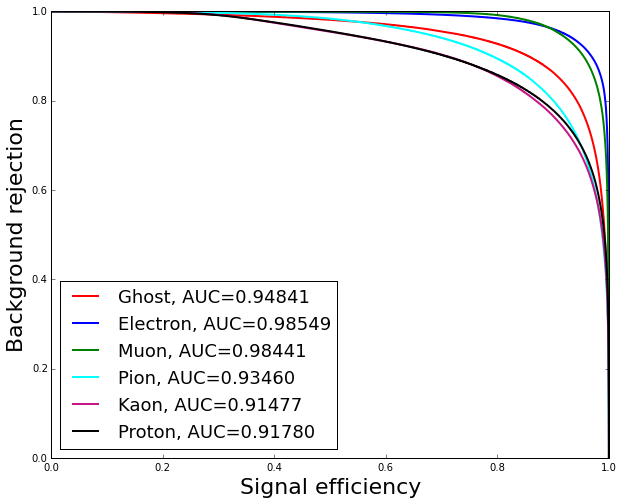

In [28]:
plot_roc_one_vs_rest(data_test.Signal, preds, data_test.Weight)
plt.savefig('img/baseline/overall_roc_auc.png', format='png')

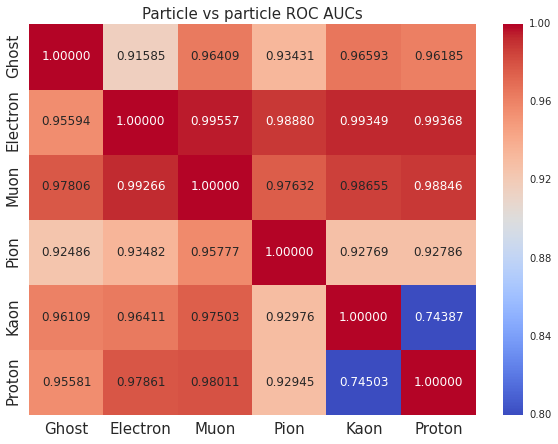

In [35]:
matrix_auc_one_vs_one = compute_roc_auc_matrix(data_test.Signal.values, preds, data_test.Weight.values)
plt.savefig('img/baseline/class_vs_class_roc_auc_matrix.png', format='png')

In [36]:
matrix_auc_one_vs_one.to_csv('img/baseline/class_vs_class_roc_auc_matrix.csv')

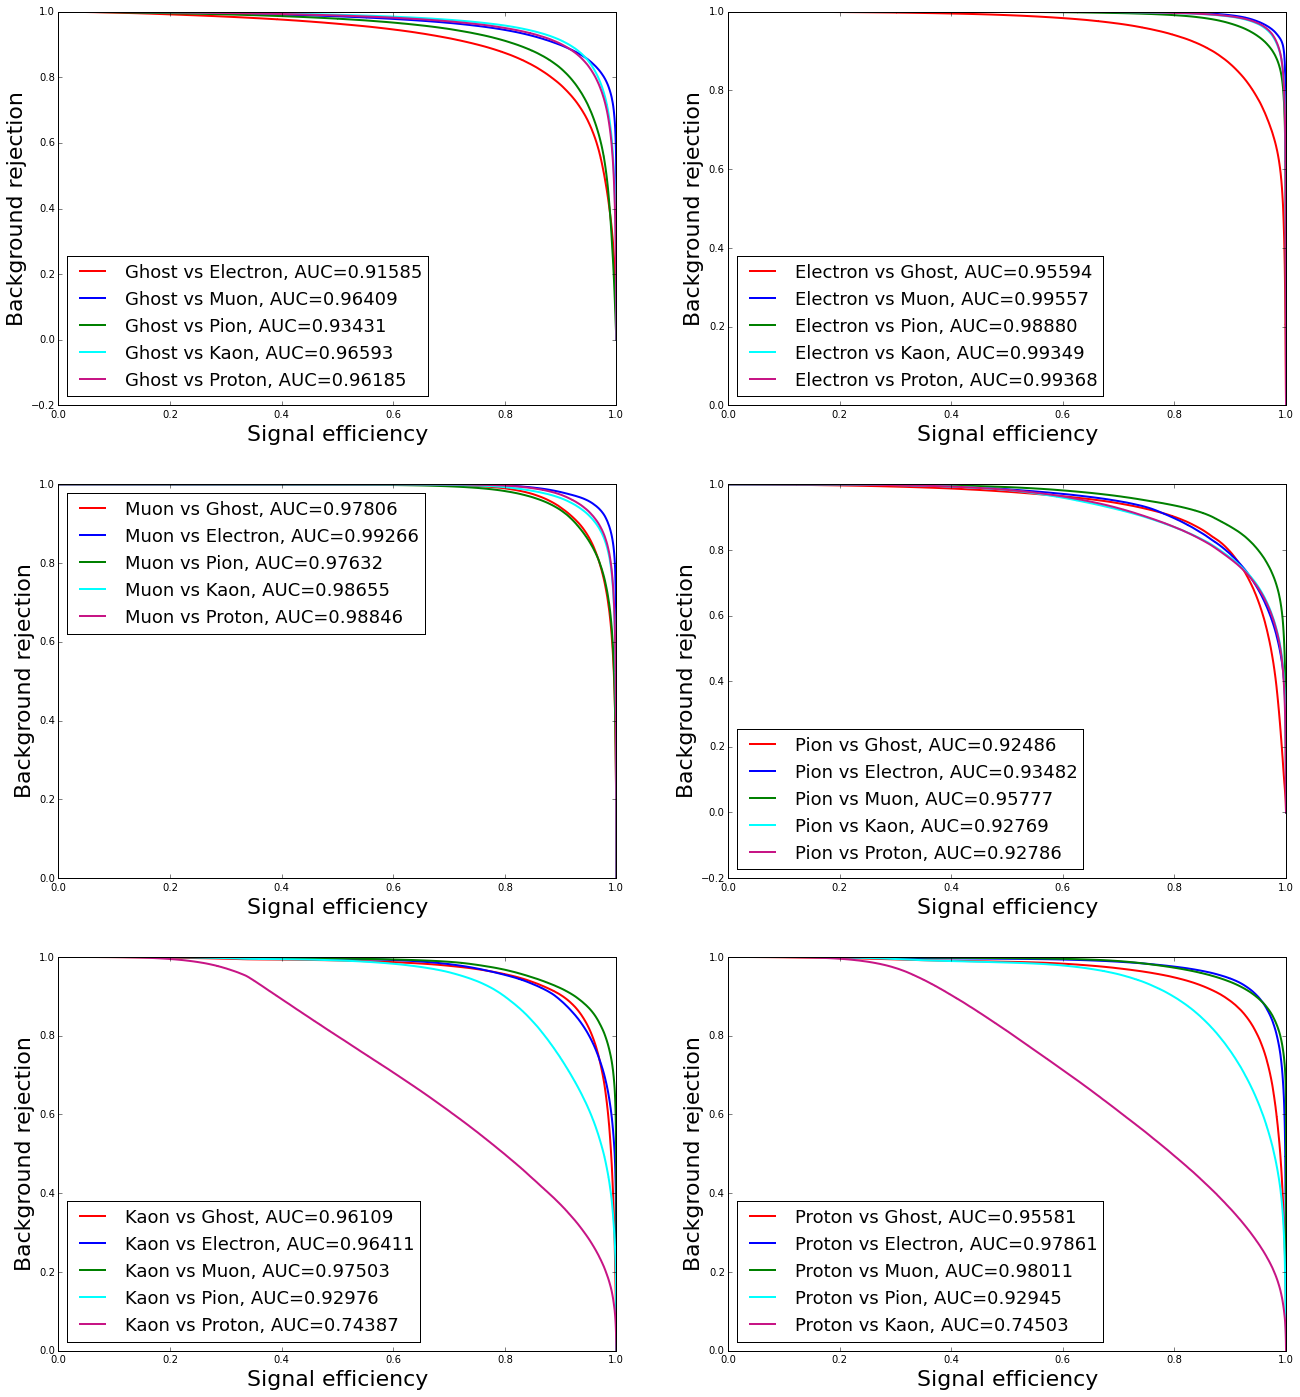

In [29]:
plot_roc_one_vs_one(data_test.Signal.values, preds, data_test.Weight.values)
plt.savefig('img/baseline/one_vs_one_roc_auc.png', format='png')

# Flatness

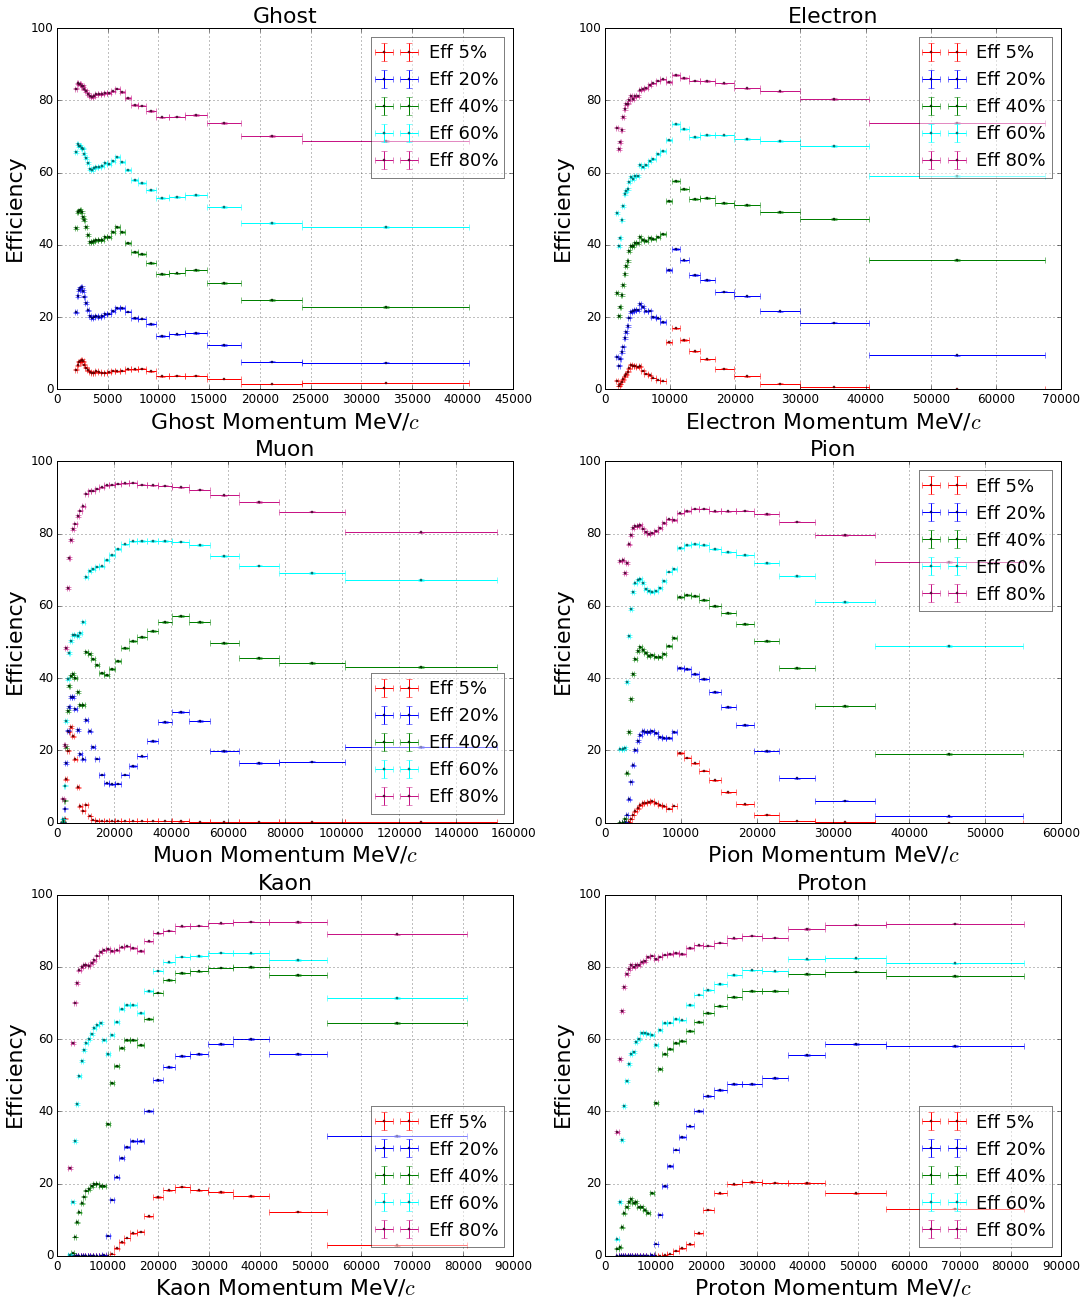

In [30]:
plot_flatness_by_particle(data_test.Signal.values, preds, data_test.TrackP.values,
                          'Momentum MeV/$c$', thresholds=[5, 20, 40, 60, 80], weights=data_test.Weight.values, 
                          ignored_sideband=0.02)
plt.savefig('img/baseline/p_flatness.png', format='png')

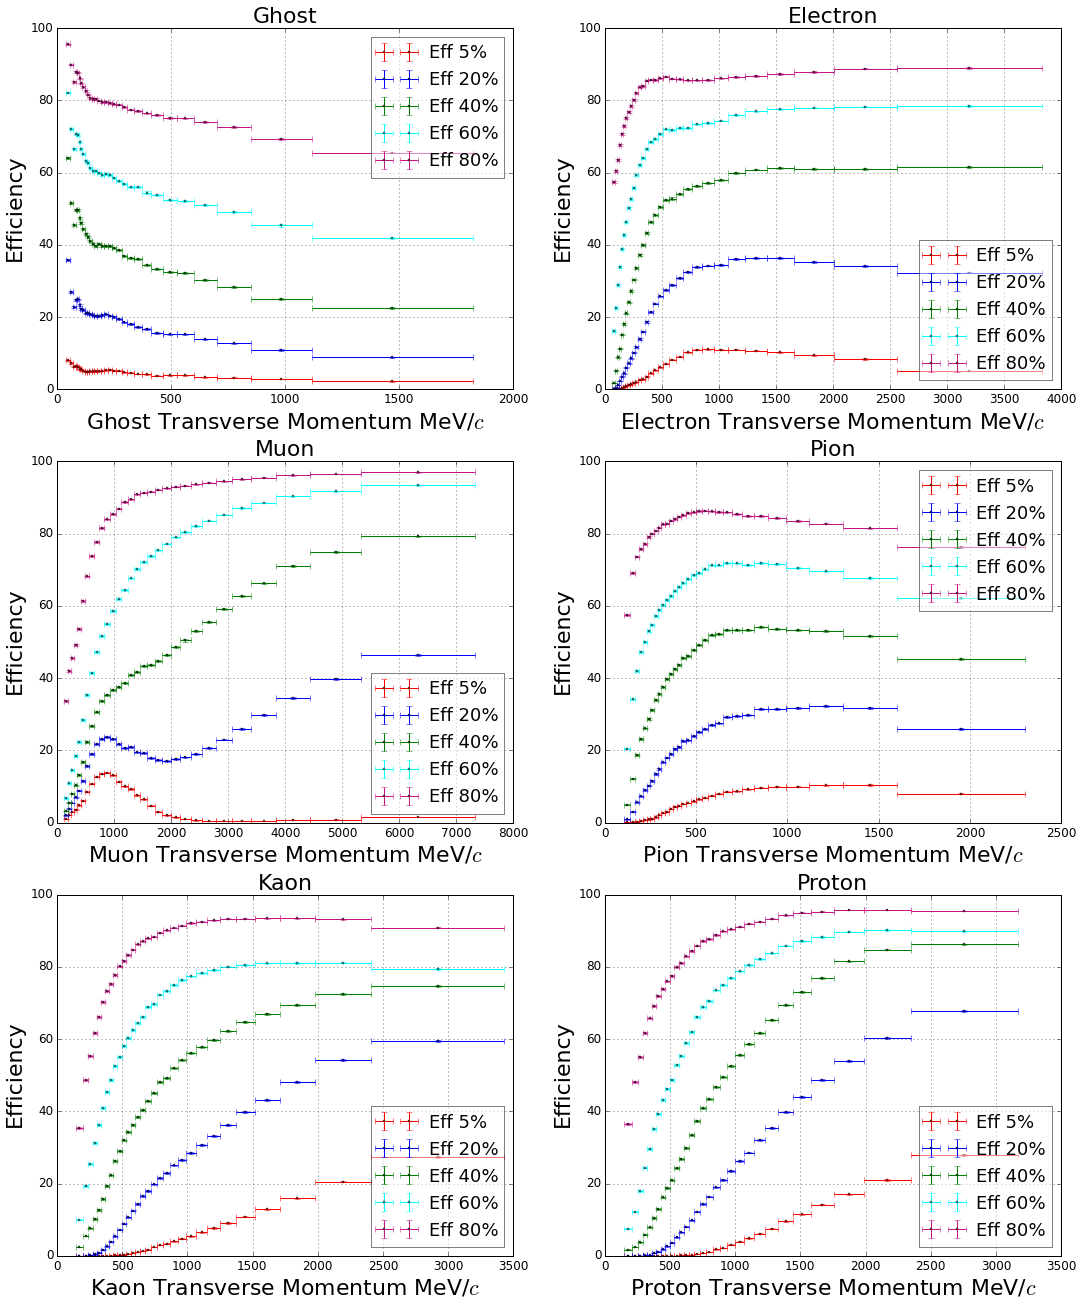

In [31]:
plot_flatness_by_particle(data_test.Signal.values, preds, data_test.TrackPt.values,
                          'Transverse Momentum MeV/$c$', thresholds=[5, 20, 40, 60, 80],
                          weights=data_test.Weight.values, 
                          ignored_sideband=0.02)
plt.savefig('img/baseline/pt_flatness.png', format='png')

In [32]:
cvm_values = compute_cvm_by_particle(data_test.Signal.values, preds, 
                                     {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

In [33]:
cvm_values

,TrackP,TrackPt
Ghost,0.003707,0.006480
Electron,0.007750,0.021756
Muon,0.026489,0.035962
Pion,0.020184,0.013491
Kaon,0.042760,0.032328
Proton,0.037028,0.043761


In [34]:
cvm_values.to_csv('img/baseline/flatness.csv')